In [24]:
import pandas as pd
import numpy as np

In [25]:
pip install pandas numpy matplotlib seaborn adjustText --break-system-packages

Note: you may need to restart the kernel to use updated packages.


In [26]:
"""
Heating Violations Analysis - Code Violations Dataset
Syracuse Winter Vulnerability Index - Phase 2

This script analyzes heating-related violations from Syracuse Open Data
to identify neighborhoods with the highest concentration of heating issues.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

# ==============================================================================
# STEP 1: LOAD AND EXPLORE DATA
# ==============================================================================

# Load the dataset
my_data = pd.read_csv('Open_Data_Project/Code_Violations_V2.csv')

# Quick look at the data
print("Dataset shape:", my_data.shape)
print("\nFirst few rows:")
print(my_data.head())

print("\nColumn names:")
print(my_data.columns.tolist())

# Look at complaint types across the dataset
print("\nComplaint type counts:")
complaint_counts = my_data['complaint_type_name'].value_counts()
print(complaint_counts)

Dataset shape: (137663, 25)

First few rows:
              X             Y           SBL    complaint_address  \
0 -8.479951e+06  5.319677e+06  109.-08-18.0  604-06 Richmond Ave   
1 -8.479951e+06  5.319677e+06  109.-08-18.0  604-06 Richmond Ave   
2 -8.479951e+06  5.319677e+06  109.-08-18.0  604-06 Richmond Ave   
3 -8.479951e+06  5.319677e+06  109.-08-18.0  604-06 Richmond Ave   
4 -8.479951e+06  5.319677e+06  109.-08-18.0  604-06 Richmond Ave   

   complaint_zip complaint_number       complaint_type_name  violation_id  \
0          13204       2025-09785  Property Maintenance-Int        209938   
1          13204       2025-09785  Property Maintenance-Int        209937   
2          13204       2025-09775  Property Maintenance-Int        209933   
3          13204       2025-09775  Property Maintenance-Int        209932   
4          13204       2025-04369  Property Maintenance-Int        198146   

                    open_date violation_number  ...           issued_to  \
0  2025/

In [27]:
# ==============================================================================
# STEP 2: IDENTIFY HEATING VIOLATIONS (BROAD FILTER)
# ==============================================================================

# Searching for heating-related keywords in the violation column
heating_keywords = [
    'heat', 'heating', 'furnace', 'boiler',
    'frozen', 'cold', 'temperature', 'hvac'
]

# Creating a filter for heating-related violations
# This creates a regex pattern like: heat|heating|furnace|...
pattern = '|'.join(heating_keywords)
heating_violations = my_data[
    my_data['violation'].str.contains(pattern, case=False, na=False)
].copy()

print(f"\nTotal heating violations found: {len(heating_violations)}")

# Count violations by type
print("\nTop 20 violation types:")
print(heating_violations['violation'].value_counts().head(20))


Total heating violations found: 1647

Top 20 violation types:
violation
2020 PMCNYS - Section 602.3 - Heat supply                                          620
2020 PMCNYS - Section 505.4 - Water heating facilities                             534
2015 IMPC - 602.3 - Heat Supply                                                    214
2015 IMPC - 505.4 - Water Heating Facilities                                       104
2015 IPMC Section 602.3 Heat Supply                                                 84
2015 IPMC Section 505.4 Hot Water Temperature And Tanks                             64
2020 FCNYS- - 603.5.2 - Heating appliance installation and maintenance              12
2015 IMPC - 602.5 - Room Temperature Measurement                                     3
2015 IFC - 603.4 - Portable Unvented Heaters                                         2
2015 IFC - 915.1.3 - Forced Air Furnaces                                             2
2020 FCNYS- - 603.5 - Heating appliances                 

In [28]:
# ==============================================================================
# STEP 3: REFINE FILTER - SPACE vs WATER HEATING
# ==============================================================================

# What I have done so far is like a broad filter
# This may contain some false positives
# Like refrigerator temperature (not related to heating issues)
# hot water (maybe or maybe not a heating violation)

# So to avoid false positives - Let's build a more precise filter here:

# From above, I found there are mostly two types of violations:
# 1. Space Violations - Heating Supply, Unsafe Heating appliances etc
# 2. Water Heating Facilities - Does lack of water heating facilities indicate
#    winter hardship: Yes and No - to not lose important data I am including
#    water heating problems as well, but as a secondary category.
#    I am going to separate two issues.

space_heating_keywords = [
    'heat supply',
    'heating appliance',
    'furnace',
    'room temperature',
    'unvented heater'
]

water_heating_keywords = [
    'water heating',
    'hot water'
]

# I am classifying different types of violations here:
def classify_heating_violation(violation_text):
    """Classify heating violation into Space Heating, Water Heating, or Other"""
    if pd.isna(violation_text):
        return 'Other'
    
    violation_lower = str(violation_text).lower()
    
    # Check space heating keywords
    for keyword in space_heating_keywords:
        if keyword in violation_lower:
            return 'Space Heating'
    
    # Check water heating keywords
    for keyword in water_heating_keywords:
        if keyword in violation_lower:
            return 'Water Heating'
    
    return 'Other'

# Apply classification
my_data['heating_category'] = my_data['violation'].apply(classify_heating_violation)

# Filter to only heating violations (exclude 'Other')
heating_violations = my_data[my_data['heating_category'] != 'Other'].copy()

print(f"\nHeating violations after classification: {len(heating_violations)}")
print("\nHeating category counts:")
print(heating_violations['heating_category'].value_counts())


Heating violations after classification: 1646

Heating category counts:
heating_category
Space Heating    944
Water Heating    702
Name: count, dtype: int64


In [29]:
# ==============================================================================
# STEP 4: HANDLE MISSING NEIGHBORHOODS
# ==============================================================================

# Labelling NA neighborhoods as 'Unknown'
heating_violations['Neighborhood'] = heating_violations['Neighborhood'].fillna('Unknown')
heating_violations['Neighborhood'] = heating_violations['Neighborhood'].replace('', 'Unknown')

print(f"\nNeighborhoods with missing data: {(heating_violations['Neighborhood'] == 'Unknown').sum()}")

# ==============================================================================
# STEP 5: AGGREGATE BY NEIGHBORHOOD
# ==============================================================================

# Now, moving on we are counting number of neighborhoods that have these
# violations reported. Basically we're asking the question - where is the
# risk concentrated geographically?

# For each neighborhood, compute:
# 1. Total Space Heating Violations
# 2. Total Water Heating Violations
# 3. Total Heating Violations (combined)
# 4. Number of unique properties affected
# 5. Open vs Closed counts

heating_by_neighborhood = heating_violations.groupby('Neighborhood').agg(
    total_space_heating=('heating_category', lambda x: (x == 'Space Heating').sum()),
    total_water_heating=('heating_category', lambda x: (x == 'Water Heating').sum()),
    total_heating_violations=('heating_category', 'count'),
    unique_addresses=('complaint_address', 'nunique'),
    open_violations=('status_type_name', lambda x: (x == 'Open').sum()),
    closed_violations=('status_type_name', lambda x: (x == 'Closed').sum())
).reset_index()

# Sort by total heating violations
heating_by_neighborhood = heating_by_neighborhood.sort_values(
    'total_heating_violations', 
    ascending=False
)

print("\nTop 10 neighborhoods by total heating violations:")
print(heating_by_neighborhood.head(10))

# ==============================================================================
# STEP 6: SANITY CHECKS
# ==============================================================================

# Sanity Checks:
print(f"\nMissing neighborhood values: {heating_violations['Neighborhood'].isna().sum()}")
print("\nTop 10 neighborhoods:")
print(heating_by_neighborhood.head(10)[['Neighborhood', 'total_heating_violations']])


Neighborhoods with missing data: 9

Top 10 neighborhoods by total heating violations:
         Neighborhood  total_space_heating  total_water_heating  \
15          Northside                  179                  143   
13      Near Westside                   89                   61   
0            Brighton                   73                   49   
30  Washington Square                   66                   37   
3            Eastwood                   44                   49   
14       North Valley                   32                   49   
17           Park Ave                   43                   31   
4             Elmwood                   40                   29   
24          Southwest                   31                   24   
23          Southside                   33                   18   

    total_heating_violations  unique_addresses  open_violations  \
15                       322               234               22   
13                       150             

In [30]:
# ==============================================================================
# STEP 7: CREATE DERIVED METRICS
# ==============================================================================

# To create a version 1 of violation-based score, I am including:
# This gives us - Volume, Breadth and Urgency

# 1. Total Heating Violations
# 2. Unique Addresses
# 3. Open violations - which indicate current risk

heating_by_neighborhood['violations_per_address'] = (
    heating_by_neighborhood['total_heating_violations'] / 
    heating_by_neighborhood['unique_addresses']
)

heating_by_neighborhood['open_violation_pct'] = (
    heating_by_neighborhood['open_violations'] / 
    heating_by_neighborhood['total_heating_violations']
)

print("\nNeighborhood metrics with derived features:")
print(heating_by_neighborhood.head())

# ==============================================================================
# STEP 8: SCALE FEATURES (MIN-MAX NORMALIZATION)
# ==============================================================================

# Creating the score and selecting features that go into the score:
# The Weatherization Risk Score is based on four core signals derived from
# code violations data:
# 1. Total heating-related violations (space and water heating combined)
# 2. Number of unique properties affected
# 3. Historical prevalence of heating issues
# 4. Indicators of current unresolved risk

# Selecting Features to Scale:
features_to_scale = [
    'total_heating_violations',
    'unique_addresses',
    'open_violations'
]

def scale_minmax(series):
    """Min-Max scaling function"""
    if series.max() == series.min():
        return pd.Series([0] * len(series), index=series.index)
    return (series - series.min()) / (series.max() - series.min())

# Apply min-max scaling
for feature in features_to_scale:
    scaled_col = f"{feature}_scaled"
    heating_by_neighborhood[scaled_col] = scale_minmax(
        heating_by_neighborhood[feature]
    )

# Sanity Check:
print("\nScaled features summary:")
print(heating_by_neighborhood[[f"{f}_scaled" for f in features_to_scale]].describe())

# ==============================================================================
# STEP 9: CALCULATE RISK SCORES
# ==============================================================================

# Historical Risk Score:
# Has this neighborhood historically experienced heating-related problems
# ever and how widespread are they?

heating_by_neighborhood['historical_risk_score'] = (
    heating_by_neighborhood['total_heating_violations_scaled'] +
    heating_by_neighborhood['unique_addresses_scaled']
) / 2

# Current Risk Score:
# Which neighborhoods have ongoing heating-related problems?
heating_by_neighborhood['current_risk_score'] = (
    heating_by_neighborhood['open_violations_scaled']
)

print("\nRisk scores calculated!")
print(heating_by_neighborhood[['Neighborhood', 'historical_risk_score', 'current_risk_score']].head(10))



Neighborhood metrics with derived features:
         Neighborhood  total_space_heating  total_water_heating  \
15          Northside                  179                  143   
13      Near Westside                   89                   61   
0            Brighton                   73                   49   
30  Washington Square                   66                   37   
3            Eastwood                   44                   49   

    total_heating_violations  unique_addresses  open_violations  \
15                       322               234               22   
13                       150               100                8   
0                        122                96               10   
30                       103                75                7   
3                         93                68                2   

    closed_violations  violations_per_address  open_violation_pct  
15                300                1.376068            0.068323  
13           


=== TOP 10 NEIGHBORHOODS BY HISTORICAL RISK ===
         Neighborhood  historical_risk_score
15          Northside               1.000000
13      Near Westside               0.444534
0            Brighton               0.392336
30  Washington Square               0.317677
3            Eastwood               0.287079
17           Park Ave               0.236025
14       North Valley               0.210448
4             Elmwood               0.202486
24          Southwest               0.161365
23          Southside               0.157281

=== TOP 10 NEIGHBORHOODS BY CURRENT RISK ===
         Neighborhood  current_risk_score
15          Northside            1.000000
17           Park Ave            0.454545
0            Brighton            0.454545
10       Lincoln Hill            0.409091
21         Skunk City            0.363636
13      Near Westside            0.363636
14       North Valley            0.363636
30  Washington Square            0.318182
4             Elmwood           

/var/folders/9c/9gm285k54tz9ysvymk9gtd400000gn/T/ipykernel_5336/4213771531.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(3, 'priority'))


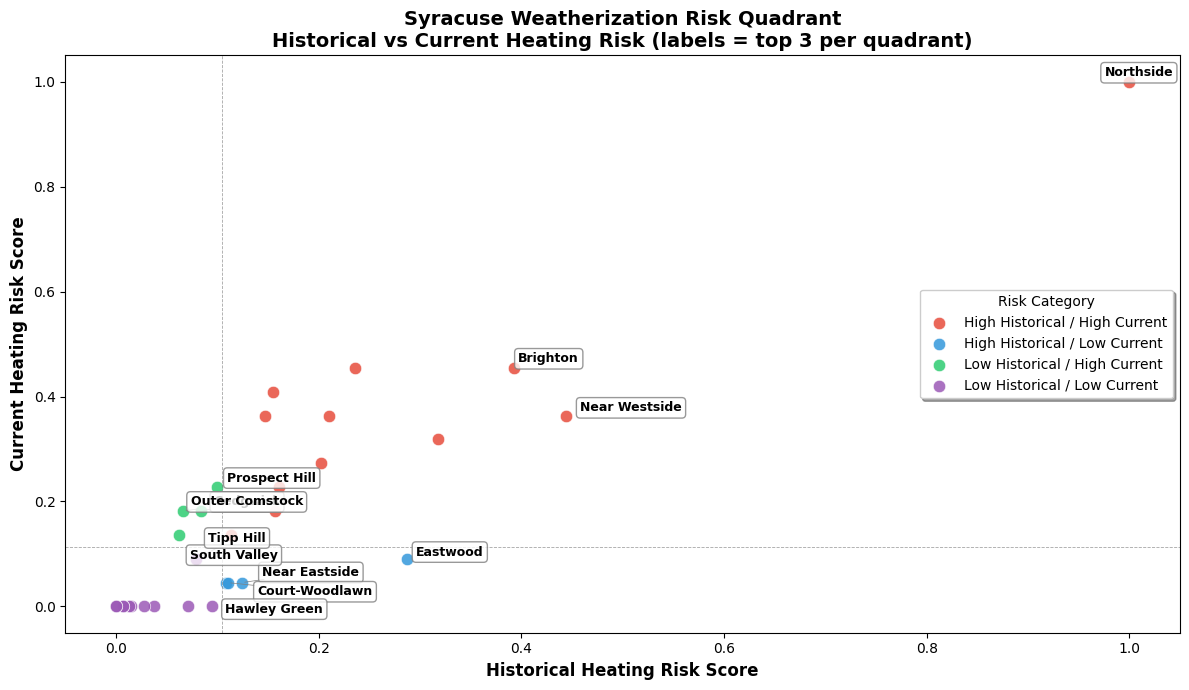

OSError: Cannot save file into a non-existent directory: 'Open_Data_Project/Cleaned'

In [33]:
# Using code violations data, I identified neighborhoods with the highest
# concentration of heating-related issues, distinguishing between space
# heating and water heating problems and accounting for repeat issues
# across properties.

# The objective behind building a scoring system is basically to understand:
# Which neighborhoods have had persistent, widespread heating problems over time?
# Current Risk Score: Which neighborhoods have ongoing heating-related problems?

# ==============================================================================
# STEP 10: RANK NEIGHBORHOODS
# ==============================================================================

# Ranking Neighborhoods by historical risk score:
print("\n=== TOP 10 NEIGHBORHOODS BY HISTORICAL RISK ===")
top_historical = heating_by_neighborhood.sort_values(
    'historical_risk_score', 
    ascending=False
)[['Neighborhood', 'historical_risk_score']].head(10)
print(top_historical)

# Ranking Neighborhoods by current risk score:
print("\n=== TOP 10 NEIGHBORHOODS BY CURRENT RISK ===")
top_current = heating_by_neighborhood.sort_values(
    'current_risk_score', 
    ascending=False
)[['Neighborhood', 'current_risk_score']].head(10)
print(top_current)

# ==============================================================================
# STEP 11: CREATE RISK QUADRANTS
# ==============================================================================

# Calculate cutoffs (median)
hist_cutoff = heating_by_neighborhood['historical_risk_score'].median()
curr_cutoff = heating_by_neighborhood['current_risk_score'].median()

print(f"\nHistorical risk cutoff (median): {hist_cutoff:.3f}")
print(f"Current risk cutoff (median): {curr_cutoff:.3f}")

# Assign risk quadrants
def assign_risk_quadrant(row):
    """Assign neighborhood to risk quadrant based on historical and current scores"""
    hist = row['historical_risk_score']
    curr = row['current_risk_score']
    
    if hist >= hist_cutoff and curr >= curr_cutoff:
        return 'High Historical / High Current'
    elif hist < hist_cutoff and curr >= curr_cutoff:
        return 'Low Historical / High Current'
    elif hist >= hist_cutoff and curr < curr_cutoff:
        return 'High Historical / Low Current'
    else:
        return 'Low Historical / Low Current'

heating_by_neighborhood['risk_quadrant'] = heating_by_neighborhood.apply(
    assign_risk_quadrant, 
    axis=1
)

# Create priority score (weighted combination)
heating_by_neighborhood['priority'] = (
    0.6 * heating_by_neighborhood['historical_risk_score'] +
    0.4 * heating_by_neighborhood['current_risk_score']
)

print("\nRisk quadrant distribution:")
print(heating_by_neighborhood['risk_quadrant'].value_counts())

# ==============================================================================
# STEP 12: VISUALIZE RISK QUADRANTS
# ==============================================================================

# Select top 3 neighborhoods per quadrant for labeling
label_df = (heating_by_neighborhood
            .groupby('risk_quadrant')
            .apply(lambda x: x.nlargest(3, 'priority'))
            .reset_index(drop=True))

print(f"\nLabeling {len(label_df)} neighborhoods (top 3 per quadrant)")

# Create the plot
fig, ax = plt.subplots(figsize=(12, 7))

# Define colors for each quadrant
colors = {
    'High Historical / High Current': '#E74C3C',    # Red
    'High Historical / Low Current': '#3498DB',     # Blue
    'Low Historical / High Current': '#2ECC71',     # Green
    'Low Historical / Low Current': '#9B59B6'       # Purple
}

# Plot all points
for quadrant, color in colors.items():
    data = heating_by_neighborhood[heating_by_neighborhood['risk_quadrant'] == quadrant]
    ax.scatter(
        data['historical_risk_score'],
        data['current_risk_score'],
        c=color,
        label=quadrant,
        s=80,
        alpha=0.85,
        edgecolors='white',
        linewidth=0.5
    )

# Add quadrant divider lines
ax.axvline(x=hist_cutoff, color='gray', linestyle='--', linewidth=0.6, alpha=0.7)
ax.axhline(y=curr_cutoff, color='gray', linestyle='--', linewidth=0.6, alpha=0.7)

# Add labels for top neighborhoods
texts = []
for _, row in label_df.iterrows():
    texts.append(
        ax.text(
            row['historical_risk_score'],
            row['current_risk_score'],
            row['Neighborhood'],
            fontsize=9,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8)
        )
    )

# Adjust text positions to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Labels and title
ax.set_xlabel('Historical Heating Risk Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Current Heating Risk Score', fontsize=12, fontweight='bold')
ax.set_title(
    'Syracuse Weatherization Risk Quadrant\nHistorical vs Current Heating Risk (labels = top 3 per quadrant)',
    fontsize=14,
    fontweight='bold'
)

# Legend
ax.legend(
    title='Risk Category',
    loc='best',
    frameon=True,
    fancybox=True,
    shadow=True
)

# Grid
ax.grid(False)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('Open_Data_Project/Outputs', dpi=300, bbox_inches='tight')
# print("\n✅ Visualization saved to: outputs/figures/heating_risk_quadrant.png")

plt.show()

# ==============================================================================
# STEP 13: SAVE RESULTS
# ==============================================================================

# Save the final neighborhood analysis
heating_by_neighborhood.to_csv(
    'Open_Data_Project/Cleaned/heating_violations_by_neighborhood.csv',
    index=False
)
# print("\n✅ Results saved to: data/cleaned/heating_violations_by_neighborhood.csv")

print("\n" + "="*60)
print("HEATING VIOLATIONS ANALYSIS COMPLETE!")
print("="*60)

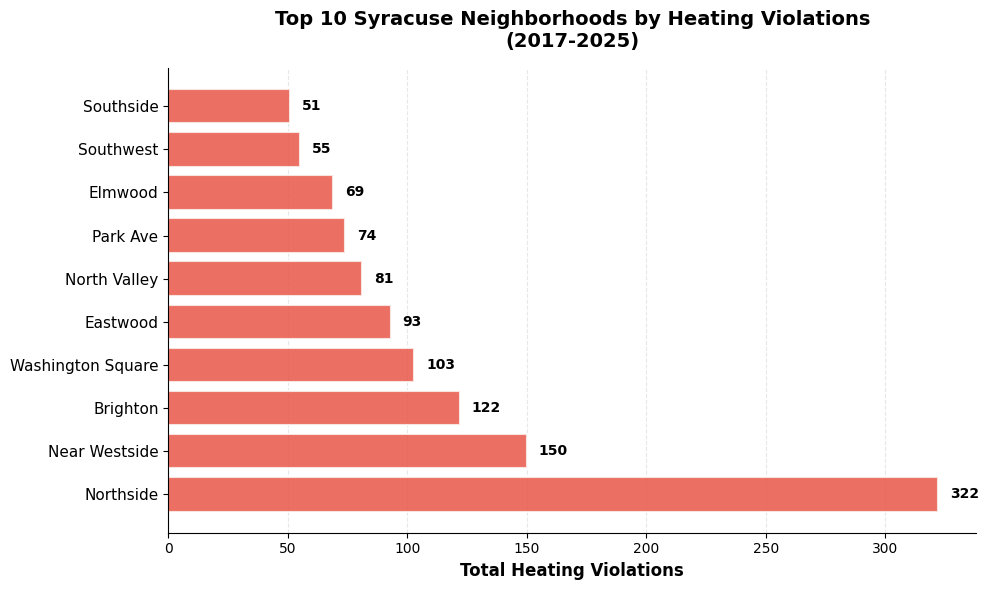

In [34]:
# ==============================================================================
# VISUALIZATION 2: TOP 10 NEIGHBORHOODS BY TOTAL HEATING VIOLATIONS
# ==============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

# Get top 10 neighborhoods
top10 = heating_by_neighborhood.head(10)

# Create horizontal bar chart
bars = ax.barh(
    range(len(top10)),
    top10['total_heating_violations'],
    color='#E74C3C',
    alpha=0.8,
    edgecolor='white',
    linewidth=1.5
)

# Add value labels on bars
for i, (idx, row) in enumerate(top10.iterrows()):
    ax.text(
        row['total_heating_violations'] + 5,
        i,
        f"{int(row['total_heating_violations'])}",
        va='center',
        fontsize=10,
        fontweight='bold'
    )

# Y-axis labels (neighborhood names)
ax.set_yticks(range(len(top10)))
ax.set_yticklabels(top10['Neighborhood'], fontsize=11)

# Labels and title
ax.set_xlabel('Total Heating Violations', fontsize=12, fontweight='bold')
ax.set_title(
    'Top 10 Syracuse Neighborhoods by Heating Violations\n(2017-2025)',
    fontsize=14,
    fontweight='bold',
    pad=15
)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add grid
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
# plt.savefig('Open_Data_Project/Outputs/top10_heating_violations.png', dpi=300, bbox_inches='tight')
# print("✅ Visualization 2 saved: outputs/figures/top10_heating_violations.png")
plt.show()

✅ Visualization 3 saved: outputs/figures/heating_types_breakdown.png


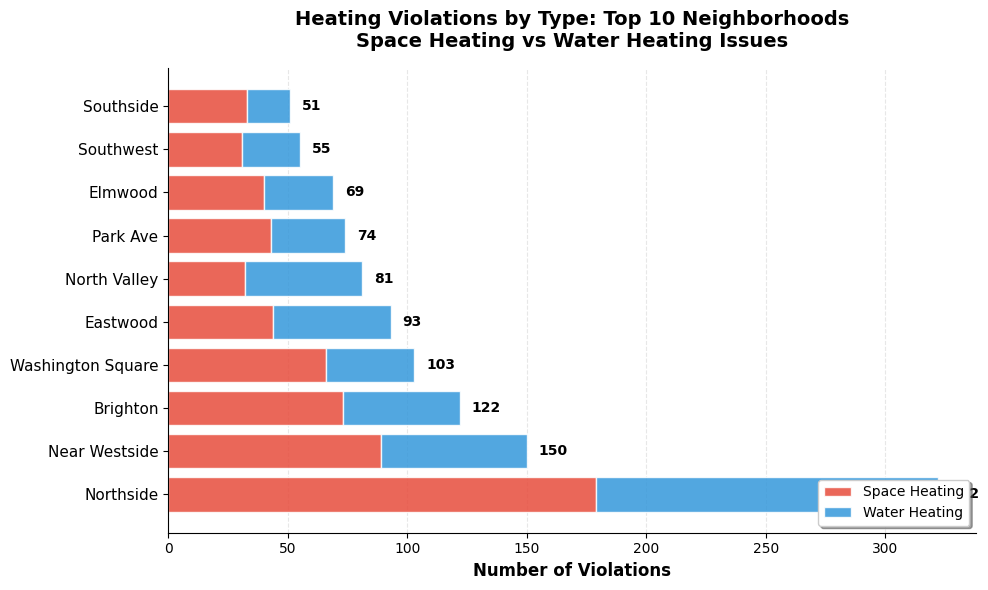

In [35]:
# ==============================================================================
# VISUALIZATION 3: SPACE HEATING VS WATER HEATING (TOP 10 NEIGHBORHOODS)
# ==============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

# Get top 10 neighborhoods
top10 = heating_by_neighborhood.head(10)

# Create stacked horizontal bar chart
y_pos = range(len(top10))

# Space heating bars (bottom)
bars1 = ax.barh(
    y_pos,
    top10['total_space_heating'],
    color='#E74C3C',
    alpha=0.85,
    label='Space Heating',
    edgecolor='white',
    linewidth=1
)

# Water heating bars (stacked on top)
bars2 = ax.barh(
    y_pos,
    top10['total_water_heating'],
    left=top10['total_space_heating'],
    color='#3498DB',
    alpha=0.85,
    label='Water Heating',
    edgecolor='white',
    linewidth=1
)

# Add total value labels at the end of bars
for i, (idx, row) in enumerate(top10.iterrows()):
    total = row['total_space_heating'] + row['total_water_heating']
    ax.text(
        total + 5,
        i,
        f"{int(total)}",
        va='center',
        fontsize=10,
        fontweight='bold'
    )

# Y-axis labels
ax.set_yticks(y_pos)
ax.set_yticklabels(top10['Neighborhood'], fontsize=11)

# Labels and title
ax.set_xlabel('Number of Violations', fontsize=12, fontweight='bold')
ax.set_title(
    'Heating Violations by Type: Top 10 Neighborhoods\nSpace Heating vs Water Heating Issues',
    fontsize=14,
    fontweight='bold',
    pad=15
)

# Legend
ax.legend(loc='lower right', frameon=True, fancybox=True, shadow=True)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Grid
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
# plt.savefig('Open_Data_Project/Outputs/heating_types_breakdown.png', dpi=300, bbox_inches='tight')
print("✅ Visualization 3 saved: outputs/figures/heating_types_breakdown.png")
plt.show()

✅ Visualization 4 saved: outputs/figures/open_vs_closed_violations.png


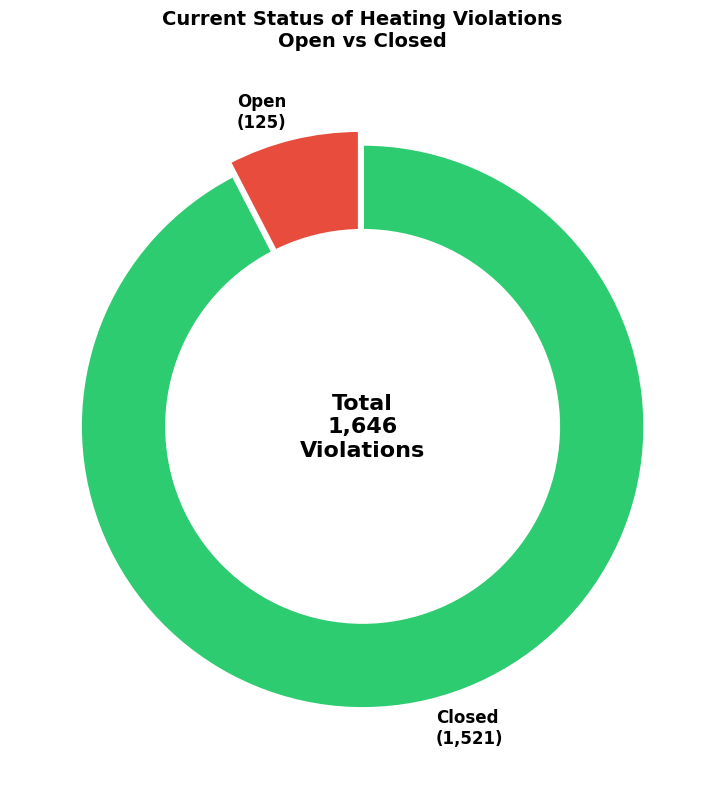

In [36]:
# ==============================================================================
# VISUALIZATION 4: OPEN VS CLOSED VIOLATIONS (OVERALL)
# ==============================================================================

fig, ax = plt.subplots(figsize=(8, 8))

# Calculate totals
total_open = heating_by_neighborhood['open_violations'].sum()
total_closed = heating_by_neighborhood['closed_violations'].sum()

# Data for pie chart
sizes = [total_open, total_closed]
labels = [f'Open\n({total_open:,})', f'Closed\n({total_closed:,})']
colors = ['#E74C3C', '#2ECC71']  # Red for open, green for closed
explode = (0.05, 0)  # Slightly separate the "Open" slice

# Create donut chart
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    explode=explode,
    textprops={'fontsize': 12, 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

# Make percentage text white and bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

# Draw circle in the center to make it a donut
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
ax.add_artist(centre_circle)

# Add center text
ax.text(
    0, 0,
    f'Total\n{total_open + total_closed:,}\nViolations',
    ha='center',
    va='center',
    fontsize=16,
    fontweight='bold'
)

# Title
ax.set_title(
    'Current Status of Heating Violations\nOpen vs Closed',
    fontsize=14,
    fontweight='bold',
    pad=20
)

plt.tight_layout()
print("✅ Visualization 4 saved: outputs/figures/open_vs_closed_violations.png")
plt.show()

In [37]:
"""
Rental Registry Analysis - Landlord Compliance Assessment
Syracuse Winter Vulnerability Index - Phase 2

This script analyzes rental property compliance with Syracuse's rental registry
requirements to identify neighborhoods with high concentrations of non-compliant
landlords.
"""

import pandas as pd
import numpy as np

# ==============================================================================
# LOAD DATA
# ==============================================================================

# The Rental Registry dataset basically answers one key question: 
# Is a rental property currently compliant with Syracuse's rental registry requirements?

rental_df = pd.read_csv('Syracuse_Rental_Registry.csv')
violation_df = pd.read_csv('Open_Data_Project/Code_Violations_V2.csv')

print("Rental Registry shape:", rental_df.shape)
print("\nFirst few rows:")
print(rental_df.head())

print("\nColumn names:")
print(rental_df.columns.tolist())



Rental Registry shape: (11085, 22)

First few rows:
              X             Y            SBL                 PropertyAddress  \
0 -8.476055e+06  5.322739e+06   010.-14-31.0  1300 Highland St & Sweeting Ss   
1 -8.478126e+06  5.324111e+06  001.1-01-22.0             829 Hiawatha Blvd E   
2 -8.476055e+06  5.322739e+06   010.-14-32.0                1304 Highland St   
3 -8.478538e+06  5.323151e+06   002.-05-02.0          326-28 Hiawatha Blvd E   
4 -8.476055e+06  5.322755e+06   010.-14-33.0                1308 Highland St   

     zip NeedsRR          inspect_period         completion_type_name  \
0  13203     Yes                     NaN                          NaN   
1  13208     Yes  2015/01/11 00:00:00+00  Rental Registry Card Issued   
2  13203     Yes  2023/01/10 00:00:00+00                          NaN   
3  13208     Yes  2025/10/22 00:00:00+00                          NaN   
4  13203     Yes  2023/01/10 00:00:00+00                          NaN   

          completion_date   

In [38]:
# ==============================================================================
# STEP 1: CREATE SBL -> NEIGHBORHOOD MAPPING
# ==============================================================================

# What exactly are we doing here: 

# 1. rental_registry does not have neighborhood information
# 2. So we are creating a bridge from the violations data, which does have neighborhood information. 
# Basically SBL -> Neighborhood
# 3. Then we attach that neighborhood to each Rental Record via SBL.

# Step1: Takes the violations dataset which has many rows per property because each property can have multiple violations
# keeps only two columns (SBL and neighborhood) and then removes exact duplicate pairs
# It makes each SBL, Neighborhood pair appear only once.

property_neighborhood = (violation_df
                        [violation_df['SBL'].notna() & (violation_df['SBL'] != '')]
                        [['SBL', 'Neighborhood']]
                        .drop_duplicates())   # one row per (SBL, Neighborhood)

print(f"\nProperty-Neighborhood mapping created: {len(property_neighborhood)} unique SBL-Neighborhood pairs")

# ==============================================================================
# STEP 2: CHECK FOR MULTI-NEIGHBORHOOD SBLS
# ==============================================================================

# We are counting how many different neighborhoods each SBL appears in:
multi_neighborhood_sbls = (property_neighborhood
                           .groupby('SBL')
                           .size()
                           .reset_index(name='n')
                           .query('n > 1')
                           .sort_values('n'))

print(f"\nSBLs appearing in multiple neighborhoods: {len(multi_neighborhood_sbls)}")
if len(multi_neighborhood_sbls) > 0:
    print("\nTop 10 SBLs with multiple neighborhoods:")
    print(multi_neighborhood_sbls.head(10))


Property-Neighborhood mapping created: 17368 unique SBL-Neighborhood pairs

SBLs appearing in multiple neighborhoods: 20

Top 10 SBLs with multiple neighborhoods:
                SBL  n
617    004.-04-26.1  2
15007  097.-04-42.1  2
11384  077.-02-28.0  2
10303  072.-15-30.0  2
10055  071.-19-21.0  2
9761   070.-02-04.0  2
8989   058.-01-01.0  2
8403   049.-16-10.0  2
6931   036.-08-01.0  2
6876   036.-01-18.0  2


In [39]:
# ==============================================================================
# STEP 3: RESOLVE MULTI-NEIGHBORHOOD ASSIGNMENTS
# ==============================================================================

# For each SBL, We look at all neighborhoods it appears in violations_data
# Counts how often each SBL appears per neighborhood. 
# Picks the most frequent neighborhood per SBL 
# Keeps only that one neighborhood - sbl unique pair
# End result here is ONE ROW PER SBL AND ONE SBL -> ONE neighborhood.

property_neighborhood_clean = (violation_df
                               [violation_df['SBL'].notna() & violation_df['Neighborhood'].notna()]
                               .groupby(['SBL', 'Neighborhood'])
                               .size()
                               .reset_index(name='n')
                               .sort_values('n', ascending=False)
                               .groupby('SBL')
                               .first()
                               .reset_index()
                               [['SBL', 'Neighborhood']])

print(f"\nCleaned property-neighborhood mapping: {len(property_neighborhood_clean)} unique SBLs")



Cleaned property-neighborhood mapping: 17274 unique SBLs


In [40]:
# ==============================================================================
# STEP 4: SANITY CHECK - VERIFY ONE-TO-ONE MAPPING
# ==============================================================================

# Sanity Check: Returns 0, that means mapping is clean. Each SBL appears in only one neighborhood.
duplicates = (property_neighborhood_clean
              .groupby('SBL')
              .size()
              .reset_index(name='n')
              .query('n > 1'))

print(f"\nSanity check - SBLs with multiple neighborhoods after cleaning: {len(duplicates)}")
if len(duplicates) == 0:
    print("✓ Mapping is clean! Each SBL appears in only one neighborhood.")

# ==============================================================================
# STEP 5: MERGE RENTAL DATA WITH NEIGHBORHOODS
# ==============================================================================

# STEP - MERGING BOTH rental_df and violations_df here:
rental_with_neighborhood = (rental_df
                           [rental_df['SBL'].notna() & (rental_df['SBL'] != '')]
                           .merge(property_neighborhood_clean, on='SBL', how='left'))

print(f"\nRental properties with neighborhoods: {len(rental_with_neighborhood)}")


Sanity check - SBLs with multiple neighborhoods after cleaning: 0
✓ Mapping is clean! Each SBL appears in only one neighborhood.

Rental properties with neighborhoods: 11085


In [42]:
# ==============================================================================
# STEP 6: ASSESS COVERAGE
# ==============================================================================

# Out of 11k Rental Properties, 27.8% of the data never appeared in the code_violations dataset.

# Simple calculation - no complex agg
total = len(rental_with_neighborhood)
missing_neighborhood = rental_with_neighborhood['Neighborhood'].isna().sum()
pct_missing = missing_neighborhood / total

print("\nCoverage Check:")
print(f"Total: {total}")
print(f"Missing neighborhood: {missing_neighborhood}")
print(f"Percent missing: {pct_missing:.1%}")

# Coverage Summary:
total_rentals = len(rental_with_neighborhood)
used_rentals = rental_with_neighborhood['Neighborhood'].notna().sum()
pct_used = used_rentals / total_rentals

print("\nCoverage Summary:")
print(f"Total rentals: {total_rentals}")
print(f"Used rentals: {used_rentals}")
print(f"Percent used: {pct_used:.1%}")

# ==============================================================================
# STEP 7: FILTER TO RENTALS WITH NEIGHBORHOODS
# ==============================================================================

# Dropping Rentals which do not have any neighborhoods associated with them here:
rental_final = rental_with_neighborhood[rental_with_neighborhood['Neighborhood'].notna()].copy()

print(f"\nFinal rental dataset: {len(rental_final)} properties")

# ==============================================================================
# STEP 8: AGGREGATE BY NEIGHBORHOOD
# ==============================================================================

# Aggregating by Neighborhood: 
# For each neighborhood, we want:
# 1. Total rental properties
# 2. Valid rentals
# 3. Invalid (non-compliant) rentals
# 4. Rental compliance rate
# 5. Rental non-compliance rate

# Filter to only true rentals
rental_filtered = rental_final[rental_final['NeedsRR'] == 'Yes'].copy()

# Create rr_valid column
def create_rr_valid(x):
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0
    else:
        return np.nan

rental_filtered['rr_valid'] = rental_filtered['RRisValid'].apply(create_rr_valid).astype('Int64')

# Group by neighborhood and summarize
rental_by_neighborhood = rental_filtered.groupby('Neighborhood').apply(
    lambda df: pd.Series({
        'rental_properties': df['SBL'].nunique(),
        'valid_rentals': df[df['rr_valid'] == 1]['SBL'].nunique() if (df['rr_valid'] == 1).any() else 0,
        'invalid_rentals': df[df['rr_valid'] == 0]['SBL'].nunique() if (df['rr_valid'] == 0).any() else 0
    })
).reset_index()

# Calculate rates
rental_by_neighborhood['rr_valid_rate'] = (
    rental_by_neighborhood['valid_rentals'] / rental_by_neighborhood['rental_properties']
)

rental_by_neighborhood['rr_invalid_rate'] = (
    rental_by_neighborhood['invalid_rentals'] / rental_by_neighborhood['rental_properties']
)

print("\nRental by Neighborhood:")
print(rental_by_neighborhood.head())

# ==============================================================================
# STEP 9: SUMMARY STATISTICS
# ==============================================================================

print("\nSummary - Rental Properties:")
print(rental_by_neighborhood['rental_properties'].describe())

print("\nSummary - Invalid Rate:")
print(rental_by_neighborhood['rr_invalid_rate'].describe())

# ==============================================================================
# STEP 10: TOP 10 BY INVALID RATE
# ==============================================================================

print("\nTop 10 by Invalid Rate:")
top10 = rental_by_neighborhood.sort_values('rr_invalid_rate', ascending=False).head(10)
print(top10[['Neighborhood', 'rr_invalid_rate']])

# ==============================================================================
# STEP 11: MERGE WITH HEATING DATA
# ==============================================================================

# Load heating_scaled data (from previous analysis)
heating_scaled = pd.read_csv('Open_Data_Project/Cleaned/heating_violations_by_neighborhood.csv')

heating_plus_rentals = heating_scaled.merge(
    rental_by_neighborhood,
    on='Neighborhood',
    how='left'
)

print(f"\nMerged dataset shape: {heating_plus_rentals.shape}")

# ==============================================================================
# STEP 12: CHECK UNIQUE RENTALS
# ==============================================================================

unique_rentals = rental_by_neighborhood['Neighborhood'].unique()
print(f"\nUnique neighborhoods in rental data: {len(unique_rentals)}")

# ==============================================================================
# CALCULATING RENTAL SCORE
# ==============================================================================

### Calculating Rental Score: 

# Step 1: In which neighborhoods are renters most exposed to unsafe or non compliant housing? 

# The answer lies in two things: 
# 1. Rental Concentration - Number of Rental Properties ()
# 2. Rental Non Compliance - % of rentals without valid RR. 

# Step 2: Scaling:

def scale_minmax(x):
    """Min-max scaling function"""
    if x.max() == x.min():
        return pd.Series([0] * len(x), index=x.index)
    return (x - x.min()) / (x.max() - x.min())

heating_plus_rentals['rental_properties_scaled'] = scale_minmax(
    heating_plus_rentals['rental_properties'].fillna(0)
)

heating_plus_rentals['rr_invalid_rate_scaled'] = scale_minmax(
    heating_plus_rentals['rr_invalid_rate'].fillna(0)
)

# Step 3: Creating Rental Risk Score:

heating_plus_rentals['rental_risk_score'] = (
    (heating_plus_rentals['rental_properties_scaled'] + 
     heating_plus_rentals['rr_invalid_rate_scaled']) / 2
)

# Step 4: Sanity Checks:

print("\nRental Risk Score Summary:")
print(heating_plus_rentals['rental_risk_score'].describe())

print("\nTop 10 by Rental Risk Score:")
top10_risk = (heating_plus_rentals
              .sort_values('rental_risk_score', ascending=False)
              [['Neighborhood', 'rental_risk_score']]
              .head(10))
print(top10_risk)

# ==============================================================================
# SAVE RESULTS
# ==============================================================================

rental_by_neighborhood.to_csv('Open_Data_Project/Cleaned/rental_Complaince', index=False)
# print("\n✓ Saved: data/cleaned/rental_compliance_by_neighborhood.csv")

heating_plus_rentals.to_csv('Open_Data_Project/Cleaned/heating_plus_rentals.csv', index=False)
# print("✓ Saved: data/cleaned/heating_plus_rentals.csv")

print("\n" + "="*60)
print("RENTAL REGISTRY ANALYSIS COMPLETE!")
print("="*60)


Coverage Check:
Total: 11085
Missing neighborhood: 3080
Percent missing: 27.8%

Coverage Summary:
Total rentals: 11085
Used rentals: 8005
Percent used: 72.2%

Final rental dataset: 8005 properties

Rental by Neighborhood:
     Neighborhood  rental_properties  valid_rentals  invalid_rentals  \
0        Brighton                686            284              402   
1  Court-Woodlawn                359            151              208   
2        Eastwood                717            369              348   
3         Elmwood                362            141              221   
4    Far Westside                274            100              174   

   rr_valid_rate  rr_invalid_rate  
0       0.413994         0.586006  
1       0.420613         0.579387  
2       0.514644         0.485356  
3       0.389503         0.610497  
4       0.364964         0.635036  

Summary - Rental Properties:
count      31.000000
mean      257.387097
std       230.062843
min         1.000000
25%       101.

/var/folders/9c/9gm285k54tz9ysvymk9gtd400000gn/T/ipykernel_5336/549839028.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rental_by_neighborhood = rental_filtered.groupby('Neighborhood').apply(


FileNotFoundError: [Errno 2] No such file or directory: 'Open_Data_Project/Cleaned/heating_violations_by_neighborhood.csv'

In [44]:
# ==============================================================================
# STEP 8: AGGREGATE BY NEIGHBORHOOD
# ==============================================================================

# Aggregating by Neighborhood: 
# For each neighborhood, we want:
# 1. Total rental properties
# 2. Valid rentals
# 3. Invalid (non-compliant) rentals
# 4. Rental compliance rate
# 5. Rental non-compliance rate

# Filter to only true rentals and create validity indicator
rental_analysis = rental_final[rental_final['NeedsRR'] == 'Yes'].copy()

rental_analysis['rr_valid'] = rental_analysis['RRisValid'].map({
    'Yes': 1,
    'No': 0
})

# Group by neighborhood and calculate metrics
rental_by_neighborhood = (rental_analysis
                         .groupby('Neighborhood')
                         .agg(
                             rental_properties=('SBL', 'nunique'),
                             valid_rentals=('SBL', lambda x: x[rental_analysis.loc[x.index, 'rr_valid'] == 1].nunique()),
                             invalid_rentals=('SBL', lambda x: x[rental_analysis.loc[x.index, 'rr_valid'] == 0].nunique())
                         )
                         .reset_index())

# Calculate rates
rental_by_neighborhood['rr_valid_rate'] = (
    rental_by_neighborhood['valid_rentals'] / rental_by_neighborhood['rental_properties']
)

rental_by_neighborhood['rr_invalid_rate'] = (
    rental_by_neighborhood['invalid_rentals'] / rental_by_neighborhood['rental_properties']
)

print("\nRental metrics by neighborhood:")
print(rental_by_neighborhood.head(10))

# ==============================================================================
# STEP 9: SUMMARY STATISTICS
# ==============================================================================

print("\nSummary - Rental Properties per Neighborhood:")
print(rental_by_neighborhood['rental_properties'].describe())

print("\nSummary - Invalid Rate per Neighborhood:")
print(rental_by_neighborhood['rr_invalid_rate'].describe())

# ==============================================================================
# STEP 10: TOP 10 NEIGHBORHOODS BY NON-COMPLIANCE
# ==============================================================================

print("\nTop 10 Neighborhoods by Rental Non-Compliance Rate:")
top10_noncompliance = rental_by_neighborhood.sort_values('rr_invalid_rate', ascending=False).head(10)
print(top10_noncompliance[['Neighborhood', 'rental_properties', 'invalid_rentals', 'rr_invalid_rate']])

# ==============================================================================
# STEP 11: MERGE WITH HEATING VIOLATIONS DATA
# ==============================================================================

# Load the heating violations analysis results
heating_scaled = pd.read_csv('Open_Data_Project/Cleaned/heating_violations_by_neighborhood.csv')

heating_plus_rentals = heating_scaled.merge(
    rental_by_neighborhood, 
    on='Neighborhood', 
    how='left'
)

print(f"\nMerged dataset: {len(heating_plus_rentals)} neighborhoods")
print(f"Neighborhoods with rental data: {heating_plus_rentals['rental_properties'].notna().sum()}")


Rental metrics by neighborhood:
     Neighborhood  rental_properties  valid_rentals  invalid_rentals  \
0        Brighton                686            284              402   
1  Court-Woodlawn                359            151              208   
2        Eastwood                717            369              348   
3         Elmwood                362            141              221   
4    Far Westside                274            100              174   
5    Hawley Green                 55             19               36   
6    Hawley-Green                  3              2                1   
7       Lakefront                 16             10                6   
8    Lincoln Hill                254            112              142   
9     Meadowbrook                 93             35               58   

   rr_valid_rate  rr_invalid_rate  
0       0.413994         0.586006  
1       0.420613         0.579387  
2       0.514644         0.485356  
3       0.389503         0.610

NameError: name 'heating_scaled' is not defined

In [44]:
# ==============================================================================
# STEP 8: AGGREGATE BY NEIGHBORHOOD
# ==============================================================================

# Aggregating by Neighborhood: 
# For each neighborhood, we want:
# 1. Total rental properties
# 2. Valid rentals
# 3. Invalid (non-compliant) rentals
# 4. Rental compliance rate
# 5. Rental non-compliance rate

# Filter to only true rentals and create validity indicator
rental_analysis = rental_final[rental_final['NeedsRR'] == 'Yes'].copy()

rental_analysis['rr_valid'] = rental_analysis['RRisValid'].map({
    'Yes': 1,
    'No': 0
})

# Group by neighborhood and calculate metrics
rental_by_neighborhood = (rental_analysis
                         .groupby('Neighborhood')
                         .agg(
                             rental_properties=('SBL', 'nunique'),
                             valid_rentals=('SBL', lambda x: x[rental_analysis.loc[x.index, 'rr_valid'] == 1].nunique()),
                             invalid_rentals=('SBL', lambda x: x[rental_analysis.loc[x.index, 'rr_valid'] == 0].nunique())
                         )
                         .reset_index())

# Calculate rates
rental_by_neighborhood['rr_valid_rate'] = (
    rental_by_neighborhood['valid_rentals'] / rental_by_neighborhood['rental_properties']
)

rental_by_neighborhood['rr_invalid_rate'] = (
    rental_by_neighborhood['invalid_rentals'] / rental_by_neighborhood['rental_properties']
)

print("\nRental metrics by neighborhood:")
print(rental_by_neighborhood.head(10))

# ==============================================================================
# STEP 9: SUMMARY STATISTICS
# ==============================================================================

print("\nSummary - Rental Properties per Neighborhood:")
print(rental_by_neighborhood['rental_properties'].describe())

print("\nSummary - Invalid Rate per Neighborhood:")
print(rental_by_neighborhood['rr_invalid_rate'].describe())

# ==============================================================================
# STEP 10: TOP 10 NEIGHBORHOODS BY NON-COMPLIANCE
# ==============================================================================

print("\nTop 10 Neighborhoods by Rental Non-Compliance Rate:")
top10_noncompliance = rental_by_neighborhood.sort_values('rr_invalid_rate', ascending=False).head(10)
print(top10_noncompliance[['Neighborhood', 'rental_properties', 'invalid_rentals', 'rr_invalid_rate']])

# ==============================================================================
# STEP 11: MERGE WITH HEATING VIOLATIONS DATA
# ==============================================================================

# Load the heating violations analysis results
heating_scaled = pd.read_csv('Open_Data_Project/Cleaned/heating_violations_by_neighborhood.csv')

heating_plus_rentals = heating_scaled.merge(
    rental_by_neighborhood, 
    on='Neighborhood', 
    how='left'
)

print(f"\nMerged dataset: {len(heating_plus_rentals)} neighborhoods")
print(f"Neighborhoods with rental data: {heating_plus_rentals['rental_properties'].notna().sum()}")


Rental metrics by neighborhood:
     Neighborhood  rental_properties  valid_rentals  invalid_rentals  \
0        Brighton                686            284              402   
1  Court-Woodlawn                359            151              208   
2        Eastwood                717            369              348   
3         Elmwood                362            141              221   
4    Far Westside                274            100              174   
5    Hawley Green                 55             19               36   
6    Hawley-Green                  3              2                1   
7       Lakefront                 16             10                6   
8    Lincoln Hill                254            112              142   
9     Meadowbrook                 93             35               58   

   rr_valid_rate  rr_invalid_rate  
0       0.413994         0.586006  
1       0.420613         0.579387  
2       0.514644         0.485356  
3       0.389503         0.610

NameError: name 'heating_scaled' is not defined

In [19]:
# ==============================================================================
# STEP 12: CHECK UNIQUE NEIGHBORHOODS
# ==============================================================================

unique_rentals = rental_by_neighborhood['Neighborhood'].unique()
print(f"\nUnique neighborhoods in rental data: {len(unique_rentals)}")

# ==============================================================================
# CALCULATING RENTAL SCORE
# ==============================================================================

### Calculating Rental Score: 

# Step 1: In which neighborhoods are renters most exposed to unsafe or non compliant housing? 

# The answer lies in two things: 
# 1. Rental Concentration - Number of Rental Properties ()
# 2. Rental Non Compliance - % of rentals without valid RR.

# Step 2: Scaling:

def scale_minmax(series):
    """Min-Max scaling function"""
    if series.max() == series.min():
        return pd.Series([0] * len(series), index=series.index)
    return (series - series.min()) / (series.max() - series.min())

heating_plus_rentals['rental_properties_scaled'] = scale_minmax(
    heating_plus_rentals['rental_properties'].fillna(0)
)

heating_plus_rentals['rr_invalid_rate_scaled'] = scale_minmax(
    heating_plus_rentals['rr_invalid_rate'].fillna(0)
)

# Step 3: Creating Rental Risk Score:

heating_plus_rentals['rental_risk_score'] = (
    heating_plus_rentals['rental_properties_scaled'] + 
    heating_plus_rentals['rr_invalid_rate_scaled']
) / 2

# Step 4: Sanity Checks:
print("\nRental Risk Score Summary:")
print(heating_plus_rentals['rental_risk_score'].describe())

print("\nTop 10 Neighborhoods by Rental Risk Score:")
top10_rental_risk = heating_plus_rentals.sort_values('rental_risk_score', ascending=False)[
    ['Neighborhood', 'rental_risk_score', 'rental_properties', 'rr_invalid_rate']
].head(10)
print(top10_rental_risk)

# ==============================================================================
# STEP 13: SAVE RESULTS
# ==============================================================================

# Save rental analysis by neighborhood
rental_by_neighborhood.to_csv(
    'Open_Data_Project/Cleaned/rental_compliance_by_neighborhood.csv',
    index=False
)
print("\n✓ Rental compliance data saved to: data/cleaned/rental_compliance_by_neighborhood.csv")

# Save merged heating + rentals dataset
heating_plus_rentals.to_csv(
    'Open_Data_Project/Cleaned/heating_plus_rentals.csv',
    index=False
)
print("✓ Merged heating + rentals data saved to: data/cleaned/heating_plus_rentals.csv")

print("\n" + "="*60)
print("RENTAL REGISTRY ANALYSIS COMPLETE!")
print("="*60)


Unique neighborhoods in rental data: 31


NameError: name 'heating_plus_rentals' is not defined

## Phase3 - Insights from Rental_Registry

In [ ]:
# ==============================================================================
# VISUALIZATION 1: TOP 10 NEIGHBORHOODS BY RENTAL NON-COMPLIANCE RATE
# ==============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

# Get top 10 neighborhoods by non-compliance rate
top10_noncompliance = rental_by_neighborhood.sort_values('rr_invalid_rate', ascending=False).head(10)

# Create horizontal bar chart
bars = ax.barh(
    range(len(top10_noncompliance)),
    top10_noncompliance['rr_invalid_rate'] * 100,  # Convert to percentage
    color='#E74C3C',
    alpha=0.8,
    edgecolor='white',
    linewidth=1.5
)

# Add value labels on bars
for i, (idx, row) in enumerate(top10_noncompliance.iterrows()):
    ax.text(
        row['rr_invalid_rate'] * 100 + 1,
        i,
        f"{row['rr_invalid_rate']*100:.1f}%",
        va='center',
        fontsize=10,
        fontweight='bold'
    )

# Y-axis labels (neighborhood names)
ax.set_yticks(range(len(top10_noncompliance)))
ax.set_yticklabels(top10_noncompliance['Neighborhood'], fontsize=11)

# Labels and title
ax.set_xlabel('Rental Non-Compliance Rate (%)', fontsize=12, fontweight='bold')
ax.set_title(
    'Top 10 Syracuse Neighborhoods by Landlord Non-Compliance\nPercentage of Rental Properties Without Valid Registry',
    fontsize=14,
    fontweight='bold',
    pad=15
)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add grid
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('Syracuse_Open_Data_Project/top10_rental_noncompliance.png', dpi=300, bbox_inches='tight')
print("✓ Visualization 1 saved: outputs/figures/top10_rental_noncompliance.png")
plt.show()

✓ Visualization 2 saved: outputs/figures/rental_concentration_vs_noncompliance.png


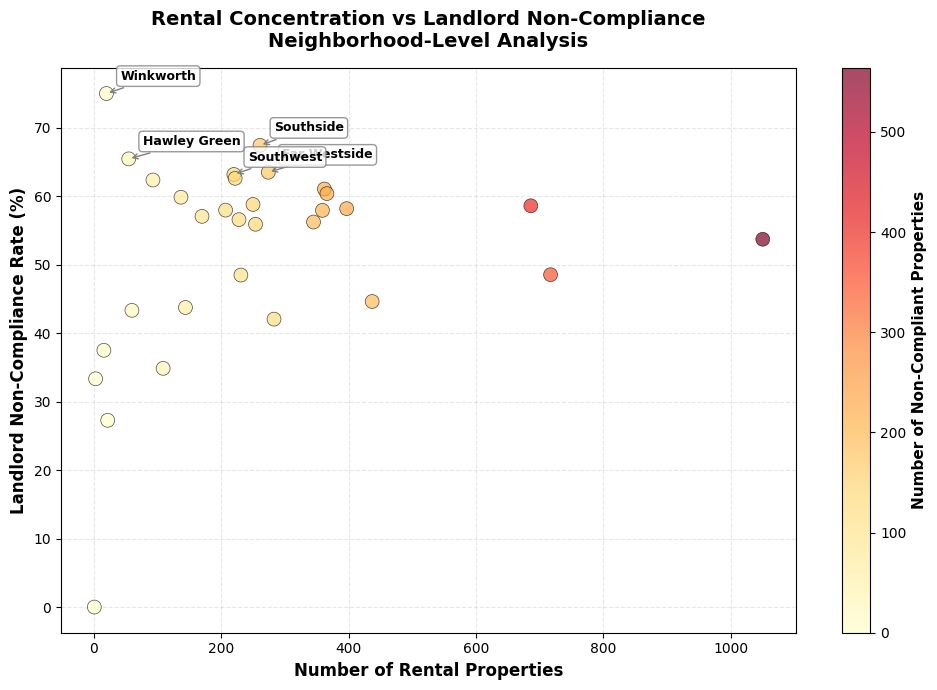

In [20]:
# ==============================================================================
# VISUALIZATION 2: RENTAL CONCENTRATION VS NON-COMPLIANCE RATE
# ==============================================================================

fig, ax = plt.subplots(figsize=(10, 7))

# Create scatter plot
scatter = ax.scatter(
    rental_by_neighborhood['rental_properties'],
    rental_by_neighborhood['rr_invalid_rate'] * 100,
    s=100,
    c=rental_by_neighborhood['invalid_rentals'],
    cmap='YlOrRd',
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Number of Non-Compliant Properties', fontsize=11, fontweight='bold')

# Label top neighborhoods (top 5 by non-compliance rate)
top5 = rental_by_neighborhood.nlargest(5, 'rr_invalid_rate')

for idx, row in top5.iterrows():
    ax.annotate(
        row['Neighborhood'],
        xy=(row['rental_properties'], row['rr_invalid_rate'] * 100),
        xytext=(10, 10),
        textcoords='offset points',
        fontsize=9,
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='gray')
    )

# Labels and title
ax.set_xlabel('Number of Rental Properties', fontsize=12, fontweight='bold')
ax.set_ylabel('Landlord Non-Compliance Rate (%)', fontsize=12, fontweight='bold')
ax.set_title(
    'Rental Concentration vs Landlord Non-Compliance\nNeighborhood-Level Analysis',
    fontsize=14,
    fontweight='bold',
    pad=15
)

# Grid
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('Syracuse_Open_Data_Project/rental_concentration_vs_noncompliance.png', dpi=300, bbox_inches='tight')
print("✓ Visualization 2 saved: outputs/figures/rental_concentration_vs_noncompliance.png")
plt.show()

✓ Visualization 3 saved: outputs/figures/rental_compliance_distribution.png


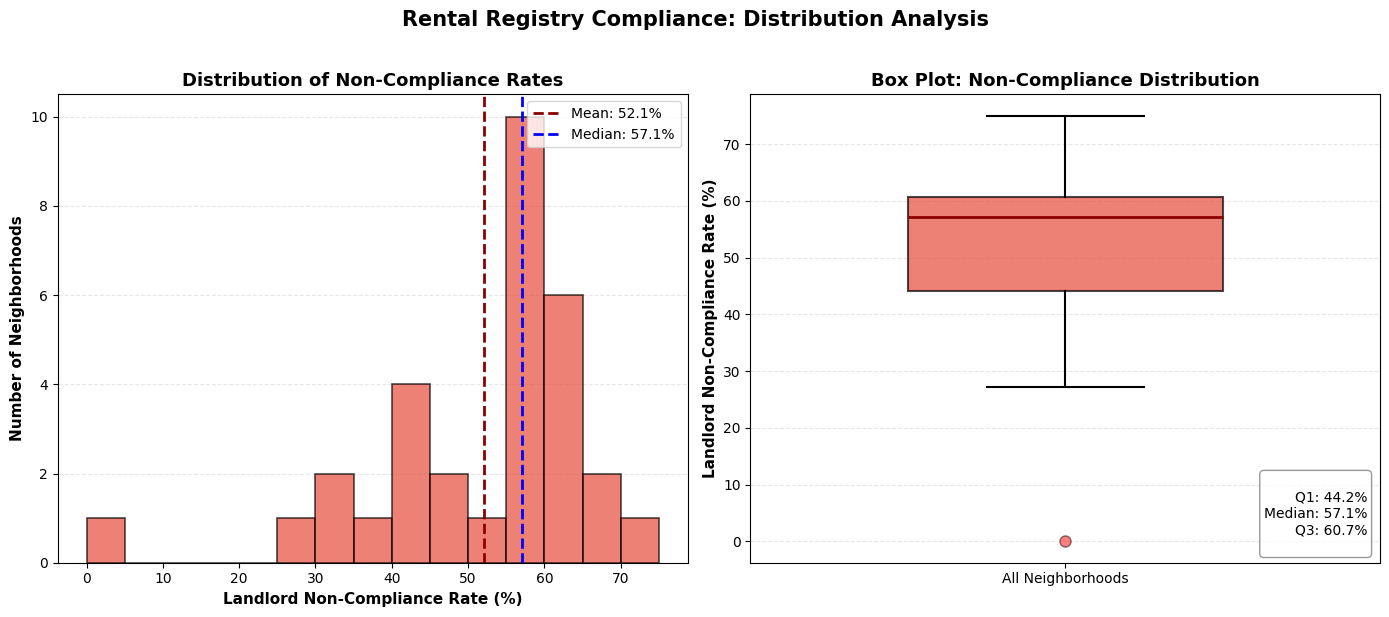

In [21]:
# ==============================================================================
# VISUALIZATION 3: DISTRIBUTION OF RENTAL COMPLIANCE RATES
# ==============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Histogram
ax1.hist(
    rental_by_neighborhood['rr_invalid_rate'] * 100,
    bins=15,
    color='#E74C3C',
    alpha=0.7,
    edgecolor='black',
    linewidth=1.2
)

# Add mean line
mean_rate = rental_by_neighborhood['rr_invalid_rate'].mean() * 100
ax1.axvline(
    mean_rate,
    color='darkred',
    linestyle='--',
    linewidth=2,
    label=f'Mean: {mean_rate:.1f}%'
)

# Add median line
median_rate = rental_by_neighborhood['rr_invalid_rate'].median() * 100
ax1.axvline(
    median_rate,
    color='blue',
    linestyle='--',
    linewidth=2,
    label=f'Median: {median_rate:.1f}%'
)

ax1.set_xlabel('Landlord Non-Compliance Rate (%)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Neighborhoods', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Non-Compliance Rates', fontsize=13, fontweight='bold')
ax1.legend(loc='upper right', frameon=True, fancybox=True)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

# Right plot: Box plot
bp = ax2.boxplot(
    rental_by_neighborhood['rr_invalid_rate'] * 100,
    vert=True,
    patch_artist=True,
    widths=0.5,
    boxprops=dict(facecolor='#E74C3C', alpha=0.7, edgecolor='black', linewidth=1.5),
    whiskerprops=dict(color='black', linewidth=1.5),
    capprops=dict(color='black', linewidth=1.5),
    medianprops=dict(color='darkred', linewidth=2),
    flierprops=dict(marker='o', markerfacecolor='red', markersize=8, alpha=0.5)
)

ax2.set_ylabel('Landlord Non-Compliance Rate (%)', fontsize=11, fontweight='bold')
ax2.set_title('Box Plot: Non-Compliance Distribution', fontsize=13, fontweight='bold')
ax2.set_xticklabels(['All Neighborhoods'])
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)

# Add statistics text
stats_text = f'''
Q1: {rental_by_neighborhood['rr_invalid_rate'].quantile(0.25)*100:.1f}%
Median: {median_rate:.1f}%
Q3: {rental_by_neighborhood['rr_invalid_rate'].quantile(0.75)*100:.1f}%
'''
ax2.text(
    0.98, 0.02, stats_text,
    transform=ax2.transAxes,
    fontsize=10,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.suptitle(
    'Rental Registry Compliance: Distribution Analysis',
    fontsize=15,
    fontweight='bold',
    y=1.02
)

plt.tight_layout()
plt.savefig('Syracuse_Open_Data_Project/rental_compliance_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Visualization 3 saved: outputs/figures/rental_compliance_distribution.png")
plt.show()

In [46]:
import pandas as pd
import numpy as np

# ==============================================================================
# LOAD DATASETS - CORRECT PATHS
# ==============================================================================

# All files are directly in Open_Data_Project folder
base_path = '/Users/saiswethalakkoju/Downloads/Open_Data_Project/'

# Load Code Violations (raw) - we need to regenerate heating_plus_rentals
my_data = pd.read_csv(base_path + 'Code_Violations_V2.csv')
rental_df = pd.read_csv(base_path + 'Syracuse_Rental_Registry.csv')
neighborhood_features = pd.read_csv(base_path + 'neighborhood_features.csv')
tract_features = pd.read_csv(base_path + 'tract_features.csv')
tract_neighborhood_map = pd.read_csv(base_path + 'tract_neighborhood_map.csv')

print("Code Violations shape:", my_data.shape)
print("Rental Registry shape:", rental_df.shape)
print("Neighborhood Features shape:", neighborhood_features.shape)
print("\nNeighborhood Features columns:", neighborhood_features.columns.tolist())
print("\nFirst few rows of neighborhood_features:")
print(neighborhood_features.head())

Code Violations shape: (137663, 25)
Rental Registry shape: (11085, 22)
Neighborhood Features shape: (30, 8)

Neighborhood Features columns: ['neighborhood', 'n_tracts', 'neighborhood_population', 'median_household_income', 'poverty_rate_pct', 'snap_households_pct', 'pct_housing_pre_1980', 'pct_housing_pre_1960']

First few rows of neighborhood_features:
     neighborhood  n_tracts  neighborhood_population  median_household_income  \
0        Brighton         3                     6329                  33846.0   
1  Court-Woodlawn         3                     9965                  68021.0   
2        Downtown         1                     3053                  62375.0   
3        Eastwood         6                    19175                  61826.5   
4         Elmwood         3                    11987                  70000.0   

   poverty_rate_pct  snap_households_pct  pct_housing_pre_1980  \
0         43.742550            47.851825             95.033333   
1         18.121044      

In [47]:
# ==============================================================================
# STEP 1: REGENERATE heating_by_neighborhood FROM CODE VIOLATIONS
# ==============================================================================

# Classify heating violations
space_heating_keywords = ['heat supply', 'heating appliance', 'furnace', 'room temperature', 'unvented heater']
water_heating_keywords = ['water heating', 'hot water']

def classify_heating_violation(violation_text):
    if pd.isna(violation_text):
        return 'Other'
    violation_lower = str(violation_text).lower()
    for keyword in space_heating_keywords:
        if keyword in violation_lower:
            return 'Space Heating'
    for keyword in water_heating_keywords:
        if keyword in violation_lower:
            return 'Water Heating'
    return 'Other'

my_data['heating_category'] = my_data['violation'].apply(classify_heating_violation)
heating_violations = my_data[my_data['heating_category'] != 'Other'].copy()
heating_violations['Neighborhood'] = heating_violations['Neighborhood'].fillna('Unknown')
heating_violations['Neighborhood'] = heating_violations['Neighborhood'].replace('', 'Unknown')

# Aggregate by neighborhood
heating_by_neighborhood = heating_violations.groupby('Neighborhood').agg(
    total_space_heating=('heating_category', lambda x: (x == 'Space Heating').sum()),
    total_water_heating=('heating_category', lambda x: (x == 'Water Heating').sum()),
    total_heating_violations=('heating_category', 'count'),
    unique_addresses=('complaint_address', 'nunique'),
    open_violations=('status_type_name', lambda x: (x == 'Open').sum()),
    closed_violations=('status_type_name', lambda x: (x == 'Closed').sum())
).reset_index()

# Scale and score
def scale_minmax(series):
    if series.max() == series.min():
        return pd.Series([0] * len(series), index=series.index)
    return (series - series.min()) / (series.max() - series.min())

heating_by_neighborhood['total_heating_violations_scaled'] = scale_minmax(heating_by_neighborhood['total_heating_violations'])
heating_by_neighborhood['unique_addresses_scaled'] = scale_minmax(heating_by_neighborhood['unique_addresses'])
heating_by_neighborhood['open_violations_scaled'] = scale_minmax(heating_by_neighborhood['open_violations'])

heating_by_neighborhood['historical_risk_score'] = (
    heating_by_neighborhood['total_heating_violations_scaled'] +
    heating_by_neighborhood['unique_addresses_scaled']
) / 2

heating_by_neighborhood['current_risk_score'] = heating_by_neighborhood['open_violations_scaled']

print("Heating by neighborhood shape:", heating_by_neighborhood.shape)
print(heating_by_neighborhood[['Neighborhood', 'historical_risk_score', 'current_risk_score']].head())

# ==============================================================================
# STEP 2: REGENERATE RENTAL BY NEIGHBORHOOD
# ==============================================================================

# Create SBL -> Neighborhood mapping
violation_df = my_data.copy()

property_neighborhood_clean = (violation_df
                               [violation_df['SBL'].notna() & violation_df['Neighborhood'].notna()]
                               .groupby(['SBL', 'Neighborhood'])
                               .size()
                               .reset_index(name='n')
                               .sort_values('n', ascending=False)
                               .groupby('SBL')
                               .first()
                               .reset_index()
                               [['SBL', 'Neighborhood']])

# Merge rental with neighborhoods
rental_with_neighborhood = (rental_df
                           [rental_df['SBL'].notna() & (rental_df['SBL'] != '')]
                           .merge(property_neighborhood_clean, on='SBL', how='left'))

rental_final = rental_with_neighborhood[rental_with_neighborhood['Neighborhood'].notna()].copy()

# Aggregate rentals
rental_filtered = rental_final[rental_final['NeedsRR'] == 'Yes'].copy()

def create_rr_valid(x):
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0
    else:
        return np.nan

rental_filtered['rr_valid'] = rental_filtered['RRisValid'].apply(create_rr_valid).astype('Int64')

rental_by_neighborhood = rental_filtered.groupby('Neighborhood').apply(
    lambda df: pd.Series({
        'rental_properties': df['SBL'].nunique(),
        'valid_rentals': df[df['rr_valid'] == 1]['SBL'].nunique() if (df['rr_valid'] == 1).any() else 0,
        'invalid_rentals': df[df['rr_valid'] == 0]['SBL'].nunique() if (df['rr_valid'] == 0).any() else 0
    })
).reset_index()

rental_by_neighborhood['rr_invalid_rate'] = (
    rental_by_neighborhood['invalid_rentals'] / rental_by_neighborhood['rental_properties']
)

print("\nRental by neighborhood shape:", rental_by_neighborhood.shape)

# ==============================================================================
# STEP 3: MERGE HEATING + RENTALS
# ==============================================================================

heating_plus_rentals = heating_by_neighborhood.merge(
    rental_by_neighborhood,
    on='Neighborhood',
    how='left'
)

# Calculate rental risk score
heating_plus_rentals['rental_properties_scaled'] = scale_minmax(heating_plus_rentals['rental_properties'].fillna(0))
heating_plus_rentals['rr_invalid_rate_scaled'] = scale_minmax(heating_plus_rentals['rr_invalid_rate'].fillna(0))

heating_plus_rentals['rental_risk_score'] = (
    heating_plus_rentals['rental_properties_scaled'] +
    heating_plus_rentals['rr_invalid_rate_scaled']
) / 2

print("\nHeating + Rentals shape:", heating_plus_rentals.shape)

# ==============================================================================
# STEP 4: CHECK NAMES BEFORE FINAL MERGE
# ==============================================================================

# Print both sides so we can see mismatches
heating_names = sorted(heating_plus_rentals['Neighborhood'].unique())
census_names = sorted(neighborhood_features['neighborhood'].unique())

print("\n=== Heating + Rentals Neighborhoods ===")
print(heating_names)

print("\n=== Census Neighborhoods ===")
print(census_names)

# Find mismatches
heating_set = set(heating_names)
census_set = set(census_names)

print("\n=== In Heating but NOT in Census ===")
print(heating_set - census_set)

print("\n=== In Census but NOT in Heating ===")
print(census_set - heating_set)

Heating by neighborhood shape: (32, 12)
     Neighborhood  historical_risk_score  current_risk_score
0        Brighton               0.392336            0.454545
1  Court-Woodlawn               0.110518            0.045455
2        Downtown               0.012668            0.000000
3        Eastwood               0.287079            0.090909
4         Elmwood               0.202486            0.272727

Rental by neighborhood shape: (31, 5)

Heating + Rentals shape: (32, 19)

=== Heating + Rentals Neighborhoods ===
['Brighton', 'Court-Woodlawn', 'Downtown', 'Eastwood', 'Elmwood', 'Far Westside', 'Franklin Square', 'Hawley Green', 'Hawley-Green', 'Lakefront', 'Lincoln Hill', 'Meadowbrook', 'Near Eastside', 'Near Westside', 'North Valley', 'Northside', 'Outer Comstock', 'Park Ave', 'Prospect Hill', 'Salt Springs', 'Sedgwick', 'Skunk City', 'South Valley', 'Southside', 'Southwest', 'Strathmore', 'Tipp Hill', 'University Hill', 'University Neighborhood', 'Unknown', 'Washington Square', 'We

/var/folders/9c/9gm285k54tz9ysvymk9gtd400000gn/T/ipykernel_5336/3218219746.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rental_by_neighborhood = rental_filtered.groupby('Neighborhood').apply(


In [48]:
# ==============================================================================
# STEP 5: FIX NAMING MISMATCHES
# ==============================================================================

# Combine Hawley Green and Hawley-Green into one
# First check what both rows look like
print("=== Hawley Green rows ===")
print(heating_plus_rentals[heating_plus_rentals['Neighborhood'].isin(['Hawley Green', 'Hawley-Green'])])

# Combine both into "Hawley Green"
hawley_green = heating_plus_rentals[heating_plus_rentals['Neighborhood'].isin(['Hawley Green', 'Hawley-Green'])].copy()
hawley_combined = hawley_green.sum(numeric_only=True).to_frame().T
hawley_combined['Neighborhood'] = 'Hawley Green'

# Remove both Hawley rows and add the combined one
heating_plus_rentals = heating_plus_rentals[~heating_plus_rentals['Neighborhood'].isin(['Hawley Green', 'Hawley-Green'])]
heating_plus_rentals = pd.concat([heating_plus_rentals, hawley_combined], ignore_index=True)

# Drop "Unknown" - not a real neighborhood
heating_plus_rentals = heating_plus_rentals[heating_plus_rentals['Neighborhood'] != 'Unknown']

# Recalculate scores after combining Hawley Green
heating_plus_rentals['rental_properties_scaled'] = scale_minmax(heating_plus_rentals['rental_properties'].fillna(0))
heating_plus_rentals['rr_invalid_rate_scaled'] = scale_minmax(heating_plus_rentals['rr_invalid_rate'].fillna(0))
heating_plus_rentals['rental_risk_score'] = (
    heating_plus_rentals['rental_properties_scaled'] +
    heating_plus_rentals['rr_invalid_rate_scaled']
) / 2

print(f"\nHeating + Rentals after cleanup: {len(heating_plus_rentals)} neighborhoods")

# ==============================================================================
# STEP 6: FINAL MERGE WITH CENSUS DATA
# ==============================================================================

# Merge - using neighborhood name on both sides
weatherization_full = heating_plus_rentals.merge(
    neighborhood_features,
    left_on='Neighborhood',
    right_on='neighborhood',
    how='outer'
)

# ==============================================================================
# STEP 7: CHECK MERGE QUALITY
# ==============================================================================

print("\n=== MERGE RESULTS ===")
print(f"Total neighborhoods: {len(weatherization_full)}")

print("\n=== COVERAGE CHECK ===")
print(f"Has heating data: {weatherization_full['historical_risk_score'].notna().sum()}")
print(f"Has rental data: {weatherization_full['rental_risk_score'].notna().sum()}")
print(f"Has census data: {weatherization_full['median_household_income'].notna().sum()}")
print(f"Has ALL three: {weatherization_full[['historical_risk_score', 'rental_risk_score', 'median_household_income']].notna().all(axis=1).sum()}")

# Which neighborhoods are missing what
print("\n=== MISSING DATA BREAKDOWN ===")
for _, row in weatherization_full.iterrows():
    name = row['Neighborhood'] if pd.notna(row['Neighborhood']) else row['neighborhood']
    missing = []
    if pd.isna(row['historical_risk_score']): missing.append('Heating')
    if pd.isna(row['rental_risk_score']): missing.append('Rental')
    if pd.isna(row['median_household_income']): missing.append('Census')
    if missing:
        print(f"  {name}: missing {', '.join(missing)}")

# ==============================================================================
# STEP 8: CLEAN UP DUPLICATE NAME COLUMNS
# ==============================================================================

# We have both 'Neighborhood' and 'neighborhood' columns - keep one clean column
weatherization_full['Neighborhood'] = weatherization_full['Neighborhood'].fillna(weatherization_full['neighborhood'])
weatherization_full = weatherization_full.drop(columns=['neighborhood'])

print("\n=== FINAL MERGED DATASET ===")
print(f"Shape: {weatherization_full.shape}")
print(f"Columns: {weatherization_full.columns.tolist()}")

# ==============================================================================
# STEP 9: SHOW KEY VARIABLES
# ==============================================================================

key_vars = [
    'Neighborhood',
    'historical_risk_score',
    'current_risk_score',
    'rental_risk_score',
    'median_household_income',
    'poverty_rate_pct',
    'snap_households_pct',
    'pct_housing_pre_1980'
]

print("\n=== KEY VARIABLES SUMMARY ===")
print(weatherization_full[key_vars].to_string())

# ==============================================================================
# STEP 10: SAVE FINAL MERGED DATASET
# ==============================================================================

weatherization_full.to_csv(
    '/Users/saiswethalakkoju/Downloads/Open_Data_Project/weatherization_full_data.csv',
    index=False
)
print("\n✓ Saved: weatherization_full_data.csv")

=== Hawley Green rows ===
   Neighborhood  total_space_heating  total_water_heating  \
7  Hawley Green                   25                    8   
8  Hawley-Green                    3                    0   

   total_heating_violations  unique_addresses  open_violations  \
7                        33                22                0   
8                         3                 3                0   

   closed_violations  total_heating_violations_scaled  \
7                 33                         0.099688   
8                  3                         0.006231   

   unique_addresses_scaled  open_violations_scaled  historical_risk_score  \
7                 0.090129                     0.0               0.094909   
8                 0.008584                     0.0               0.007407   

   current_risk_score  rental_properties  valid_rentals  invalid_rentals  \
7                 0.0               55.0           19.0             36.0   
8                 0.0              